# PyTorch Implementation of VGG-16 using Cat-Dog Dataset (Kaggle)

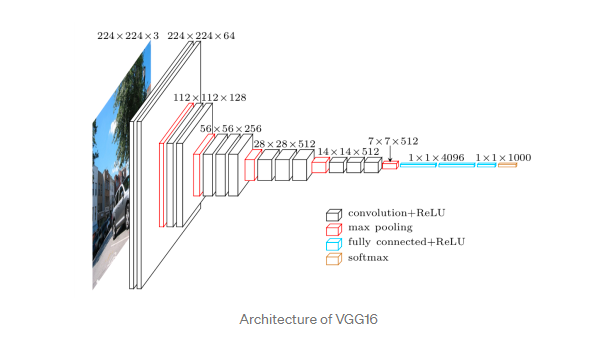



Link: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats

## **How to Use the Notebook**

*   Download the dataset using the link above^
*   If you want to run the dataset with fewer examples import vgg_scriptData!

---

**Usage (vgg_scriptData)**
*   customDatasetPath, catPath, dogPath = **dataSeparator**("data/CAT_DOGDataset", 500)
*   **splitCustomDataset**(customDatasetPath, catPath, dogPath, 0.8, 0.2)




## Script to Divide Dataset

In [ ]:
from vggDataPrep import dataSeparator, splitCustomDataset

customDatasetPath, catPath, dogPath = dataSeparator("data/CAT_DOG", 500)  # 250 to Each Category
splitCustomDataset(customDatasetPath, catPath, dogPath, 0.8, 0.2)         # 80/20 Train & Test Split

## Loading Libaries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Pre-Processing

In [ ]:
# Hyper-Paramerters
train_split = 0
test_split = 0

# images
input_channel = 3
classes = ('cat', 'dog')

In [ ]:
# Transformation
transforms = transforms.Compose([
                    transforms.Resize(size = (224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])

### Loading Dataset

In [ ]:
# Extractin the Dataset
train_data = torchvision.datasets.ImageFolder('./data/catDogDataset/train', transform = transforms)
test_data = torchvision.datasets.ImageFolder('./data/catDogDataset/test', transform = transforms)

In [ ]:
# Loading to PyTorch
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

## Visualizing

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')

## Defining Model

### Setting Model Parameters

In [ ]:
# Hyper-parameters
learning_rate = 0.0005
num_epochs = 2
batch_size = 20


## Model Definition

In [ ]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding='same')
        self.batchnorm1_1 = nn.BatchNorm2d(64)
        self.conv1 = nn.Conv2d(64, 64, 3, padding='same')
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.5)

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding='same')
        self.batchnorm2_1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding='same')
        self.batchnorm2 = nn.BatchNorm2d(128)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding='same')
        self.batchnorm3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding='same')
        self.batchnorm3_2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 256, 3, padding='same')
        self.batchnorm3 = nn.BatchNorm2d(256)

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding='same')
        self.batchnorm4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding='same')
        self.batchnorm4_2 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 512, 3, padding='same')
        self.batchnorm4 = nn.BatchNorm2d(512)

        # Reuse 3 times as in and out channel same:
        # We could just reuse the conv4 but conv5 is just a visual separation:
        self.conv5 = nn.Conv2d(512, 512, 3, padding='same')
        self.batchnorm5 = nn.BatchNorm2d(512)

        # Fully Connected Layer
        self.fc1 = nn.Linear(7*7*512, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 2)       # Output #2 (Cat or Dog)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = self.batchnorm1_1(x)
        x = self.conv1(x)
        x = self.pool(F.relu(x))
        x = self.batchnorm1(x)

        x = F.relu(self.conv2_1(x))
        x = self.batchnorm2_1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batchnorm2(x)

        x = F.relu(self.conv3_1(x))
        x = self.batchnorm3_1(x)
        x = F.relu(self.conv3_2(x))
        x = self.batchnorm3_2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.batchnorm3(x)

        x = F.relu(self.conv4_1(x))
        x = self.batchnorm4_1(x)
        x = F.relu(self.conv4_2(x))
        x = self.batchnorm4_2(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.batchnorm4(x)


        x = F.relu(self.conv5(x))
        x = self.batchnorm5(x)
        x = F.relu(self.conv5(x))
        x = self.batchnorm5(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.batchnorm5(x)

        x = x.view(-1, 7*7*512)
        # x = x.view(-1, 48*3*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

### Assigning Model

In [ ]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
n_total_steps = len(train_loader)
print(n_total_steps)

running_loss = 0.0
running_correct = 0

### Training

In [ ]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (i+1) % 2000 == 0:
        # print (f'-----------> Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()

        if (i+1) % 100 == 0:
          print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

### Testing

In [ ]:
class_labels = []
class_preds = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

            class_probs_batch = [F.softmax(output, dim=0) for output in outputs]

            class_preds.append(class_probs_batch)
            class_labels.append(predicted)

    class_preds = torch.cat([torch.stack(batch) for batch in class_preds])
    class_labels = torch.cat(class_labels)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

    classes = range(2)
    for i in classes:
        labels_i = class_labels == i
        preds_i = class_preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()